In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [9]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [12]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            #data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 156.310645
Train Epoch: 1 [10000/60000 (17%)]	Loss: 157.727773
Train Epoch: 1 [20000/60000 (33%)]	Loss: 154.218799
Train Epoch: 1 [30000/60000 (50%)]	Loss: 155.153799
Train Epoch: 1 [40000/60000 (67%)]	Loss: 162.900840
Train Epoch: 1 [50000/60000 (83%)]	Loss: 161.074336
====> Epoch: 1 Average loss: 157.3413
====> Test set loss: 154.2440
Train Epoch: 2 [0/60000 (0%)]	Loss: 161.736904
Train Epoch: 2 [10000/60000 (17%)]	Loss: 159.287080
Train Epoch: 2 [20000/60000 (33%)]	Loss: 157.850898
Train Epoch: 2 [30000/60000 (50%)]	Loss: 146.381201
Train Epoch: 2 [40000/60000 (67%)]	Loss: 158.005469
Train Epoch: 2 [50000/60000 (83%)]	Loss: 144.675713
====> Epoch: 2 Average loss: 152.5796
====> Test set loss: 151.2995
Train Epoch: 3 [0/60000 (0%)]	Loss: 142.493740
Train Epoch: 3 [10000/60000 (17%)]	Loss: 150.376992
Train Epoch: 3 [20000/60000 (33%)]	Loss: 157.257334
Train Epoch: 3 [30000/60000 (50%)]	Loss: 146.554102
Train Epoch: 3 [40000/60000 (67%)]	Loss: 144.70

KeyboardInterrupt: 

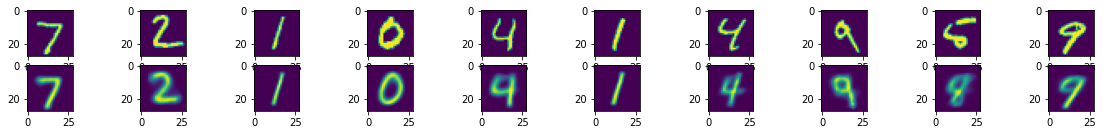

In [35]:
import matplotlib.pyplot as plt

data,_ = iter(test_loader).next()

recon, mu, logvar = vae(data)
recon = recon.detach().view(-1,1,28,28)

num = 10
plt.figure(figsize=(num*2,num*2))
for i in range(num):
    plt.subplot(num*2,num,i+1)
    plt.imshow(data[i].squeeze())
    plt.subplot(num*2,num,num+i+1)
    plt.imshow(recon[i].squeeze())

## latent space visualization

In [41]:
z_mu = list()
labels = list()
with torch.no_grad():
    for data, _ in test_loader:
        #data = data.cuda()
        mu, log_var = vae.encoder(data.view(-1, 784))
        z_mu.append(mu)
        labels.append(_)

z_mu = torch.cat(z_mu)
labels = torch.cat(labels)

torch.Size([10000])


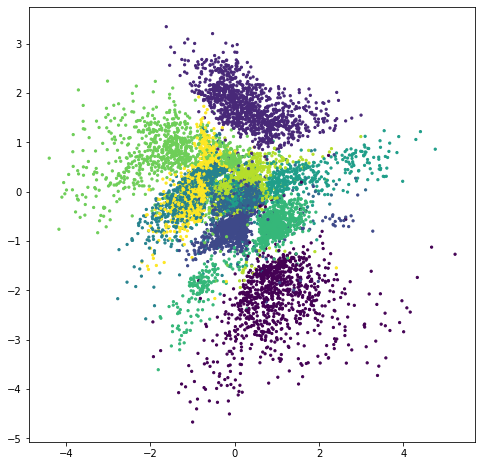

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(z_mu[:,0], z_mu[:,1], c=labels, s=5)

### OOD recon?

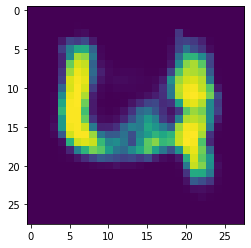

In [67]:
z = torch.tensor([[-4,-4]]).float()
out = vae.decoder(z)

plt.imshow(out.detach().squeeze().view(28,28))

In [71]:
test_dataset = datasets.FashionMNIST(root='./fmnist_data/', train=False, transform=transforms.ToTensor(), download=True)

Extracting ./fmnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist_data/FashionMNIST/raw



Extracting ./fmnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist_data/FashionMNIST/raw


Extracting ./fmnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist_data/FashionMNIST/raw


Extracting ./fmnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist_data/FashionMNIST/raw
Processing...
Done!


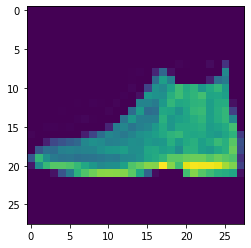

In [78]:
plt.imshow(test_dataset[0][0].squeeze())

In [79]:
test_loader_fashion = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [80]:
z_mu_fashion = list()
labels_fashion = list()
with torch.no_grad():
    for data, _ in test_loader_fashion:
        #data = data.cuda()
        mu, log_var = vae.encoder(data.view(-1, 784))
        z_mu_fashion.append(mu)
        labels_fashion.append(_)

z_mu_fashion = torch.cat(z_mu_fashion)
labels_fashion = torch.cat(labels_fashion)

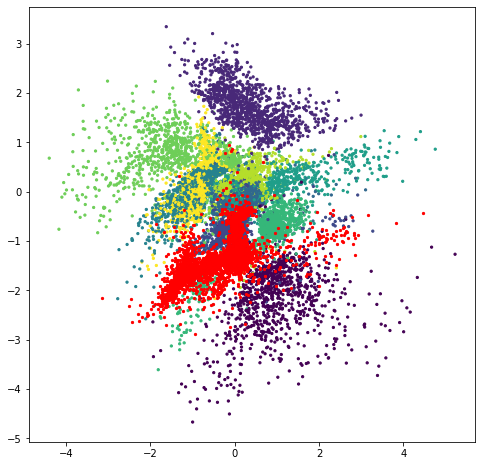

In [82]:
plt.figure(figsize=(8,8))
plt.scatter(z_mu[:,0], z_mu[:,1], c=labels, s=5)
plt.scatter(z_mu_fashion[:,0], z_mu_fashion[:,1], c='r', s=5)

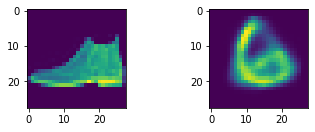

In [96]:
plt.subplot(2,2,1)
plt.imshow(test_dataset[0][0].squeeze())

recon, mu_o,log_var_o = vae(test_dataset[0][0].view(1,28*28))

plt.subplot(2,2,2)
plt.imshow(recon.detach().squeeze().view(28,28))

In [98]:
vae.sampling(mu_o, log_var_o)

tensor([[-0.5697, -1.3694]], grad_fn=<AddBackward0>)

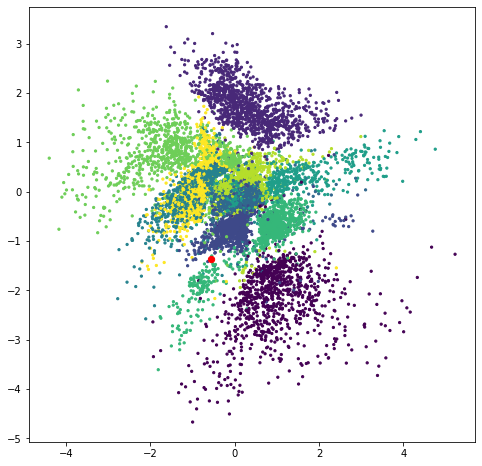

In [102]:
plt.figure(figsize=(8,8))
plt.scatter(z_mu[:,0], z_mu[:,1], c=labels, s=5)
plt.scatter(-0.5697, -1.3694, c='r', s=40)